# Defensive Distillation based Adversarial Attacks Mitigation Method for Channel Estimation using Deep Learning  Models in Next-Generation Wireless Networks

This research paper focuses on the security concerns of using artificial intelligence in future wireless networks (5G, 6G, 7G and beyond), also known as Next Generation or NextG. It is crucial to protect the next-generation cellular networks against cyber attacks, especially adversarial attacks. The paper proposes a comprehensive vulnerability analysis of deep learning (DL)-based channel estimation models trained with the dataset obtained from MATLAB’s 5G toolbox for adversarial attacks and defensive distillation-based mitigation methods. The adversarial attacks produce faulty results by manipulating trained DL-based models for channel estimation in NextG networks while making models more robust against any attacks through mitigation methods. The paper also presents the performance of the proposed defensive distillation mitigation method for each adversarial attack against the channel estimation model. The results indicated that the proposed mitigation method could defend the DL-based channel estimation models against adversarial attacks in NextG networks.

## Typical adversarial ML-based adversarial sample generation
![Adversarial Example](https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/typical_adv.png)

## Defensive Distillation

In computer security, defensive distillation is a technique for transforming a machine learning model to make it more robust to adversarial examples. The goal is to distil the knowledge from a complex model into a simpler one that is less susceptible to being fooled by adversarial examples. There are a few different ways to do defensive distillation, but the most common is to train a new, smaller model using the predictions of the original model as labels. Carlini and Wagner first proposed this technique in their 2016 paper "Towards Evaluating the Robustness of Neural Networks".

![Defensive Distillation](https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/6g-defense-channel_estimation_distill.png)


## Dataset Description

MATLAB 5G Toolbox provides a wide range of reference examples for next generation networks communications systems, such as 5G . It also allows to customize and generate several types of waveforms, antennas and channel models to obtain datasets for DL-based models.  
In this study, the dataset used to train the DL-based channel estimation models is generated through a reference example in MATLAB 5G Toolbox, i.e, "Deep Learning Data Synthesis for 5G Channel Estimation". In the example, a convolutional neural network (CNN) is used for channel estimation. Single-input single-output (SISO) antenna method is also used by utilizing the physical downlink shared channel (PDSCH) and demodulation reference signal (DM-RS) to create the channel estimation model.  The reference example in the toolbox generates 256 training datasets, i.e., transmit/receive the signal 256 times, for DL-based channel estimation model. Each dataset consists of 8568 data points, i.e., 612 subcarriers, 14 OFDM symbols,  1 antenna. However, each data point of training dataset is converted from a complex (real and imaginary) 612-14 matrix into a real-valued 612-14-2 matrix for providing inputs separately into the neural network during the training process. This is because the resource grids consisting of complex data points with real and imaginary parts in the channel estimation scenario, but CNN model manages the resource grids as 2-D images with real numbers. In this example, the training dataset is converted into 4-D arrays, i.e., 612-14-1-2N, where N presents the number of training examples, i.e., 256.  For each set of the training dataset, a new channel characteristic is generated based on various channel parameters, such as delay profiles (TDL-A, TDL-B, TDL-C, TDL-D, TDL-E), delay spreads (1-300 nanosecond), doppler shifts (5-400 Hz), and Signal-to-noise ratio (SNR or S/N) changes between 0 and 10 dB. Each transmitted waveform with the DM-RS symbols is stored in the train dataset, and the perfect channel values in train labels. The CNN-based channel estimation based is trained with the generated dataset. MATLAB 5G toolbox also allows tuning several communication channel parameters, such as the frequency, subcarrier spacing, number of subcarriers, cyclic prefix type, antennas, channel paths, bandwidth,  code rate, modulation, etc. The channel estimation scenario parameters with values are given for each in the following table.

![Defensive Distillation](https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/channel_est_param.png)


## The vulnerable CNN model

![Defensive Distillation](https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/model_plot.png)

### 1. Install Libraries
You need to install the required libraries using 

`pip install <library_name>`.




In [3]:
!pip install -q cleverhans
!pip install -q plot_keras_history
!pip install -q keras-tuner

### 2. Import libraries
Import requiered libraries

In [4]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.models import load_model


from sklearn.metrics import mean_squared_error
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
import numpy as np

import seaborn as sns
import pandas as pd

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
GOOGLE_COLAB = True

PROJECT_FOLDER = ''

np.random.seed(10)

### 3. Download 
Download our dataset and Defensive Distillation Implementaion from our GitHub repository.

In [5]:
!wget -q -O data.mat https://github.com/ocatak/6g-channel-estimation-dataset/blob/main/data.mat?raw=true
!wget -q -O util_defdistill.py https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/util_defdistill.py
from util_defdistill import Distiller

### 4. Import dataset
#### 4.1 Load dataset
Convert MATLAB mat file into NumPy matrix using scipy library

In [6]:
data = scipy.io.loadmat(PROJECT_FOLDER + 'data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

4.2 Plot example inputs and outputs

Import randomly selected 2 inputs and outputs from the dataset. We visualize the inputs and outputs.

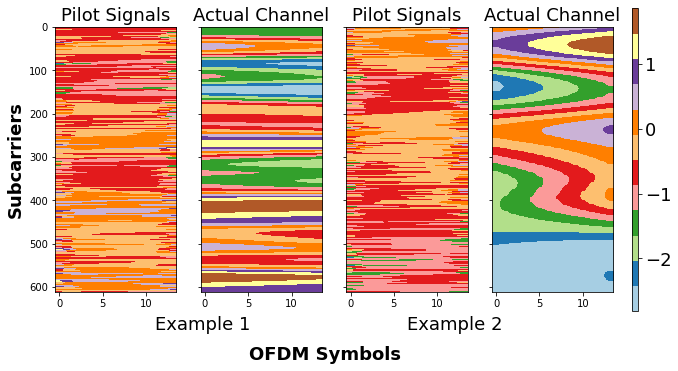

In [7]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size) 

plt.show()

### 5. Undefended Model
#### 5.1 `get_model`
This method is our model architecture. `mult_factor` parameter is the multiplication factor to set the number of neurons for each layer.

In [8]:
def get_model(mult_factor = 1.0, model_name=''):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(layers.Conv2D(int(48*mult_factor), (9, 9), padding='same', activation='selu', input_shape=(612, 14, 1)))
    model.add(layers.Conv2D(int(16*mult_factor), (5, 5), padding='same', activation='softplus'))
    model.add(layers.Conv2D(1, (5, 5),  padding='same', activation='selu'))

    return model

5.1 Undefended `Student` model
We will train the undefended student model that is same for the defended student model. In this jupyter notebook there are 3 CNN models
- undefended student model (variable name: `model`)
- defended student model (variable name: `student_model`)
- teacher model (variable name: `teacher_model`).

Train `model` and plot the training history

In [9]:
STUDENT_MODEL_MULTIPLICATION = 0.5
TEACHER_MODEL_MULTIPLICATION = 1.0

model = get_model(STUDENT_MODEL_MULTIPLICATION, model_name = 'Student')

es_teacher = EarlyStopping(monitor='val_loss', 
                          patience=50, 
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_model = model.fit(trainData, trainLabels, 
              epochs=100000,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 823.
Epoch 873: early stopping


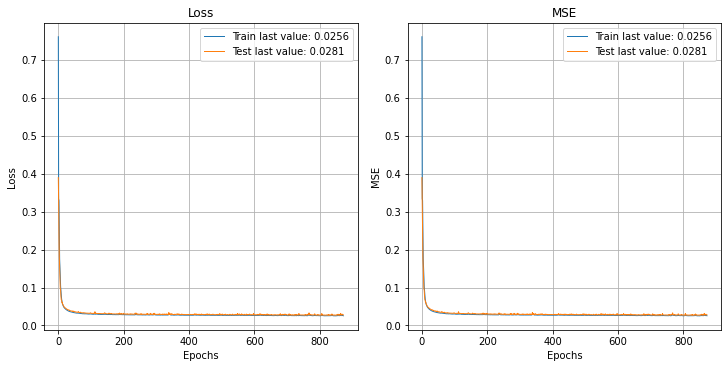

In [10]:
plot_history(hist_model.history)
plt.show()

Plot the input, actual outpu and predicted output.

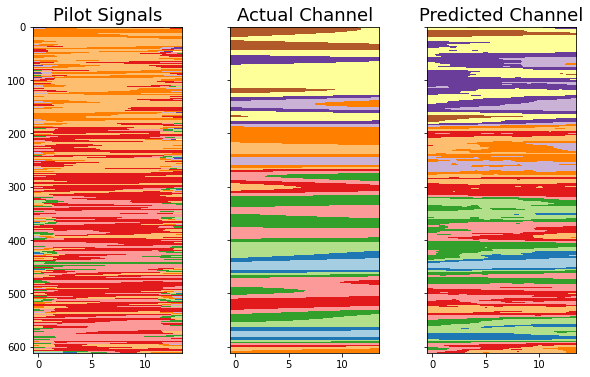

In [11]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

### 6. Defensive Distillation
Create teacher and student models

In [12]:
student_model = get_model(STUDENT_MODEL_MULTIPLICATION, model_name = 'Student')
teacher_model = get_model(TEACHER_MODEL_MULTIPLICATION, model_name = 'Teacher')

#print('*'*70)
#student_model.summary()
#print('*'*70)
#teacher_model.summary()
#print('*'*70)

6.1 Teacher Model

Train the teacher model and make example prediction.

In [13]:
es_teacher = EarlyStopping(monitor='val_loss', 
                          patience=200, 
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

teacher_model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_teacher = teacher_model.fit(trainData, trainLabels, 
              epochs=100000,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 2286.
Epoch 2486: early stopping


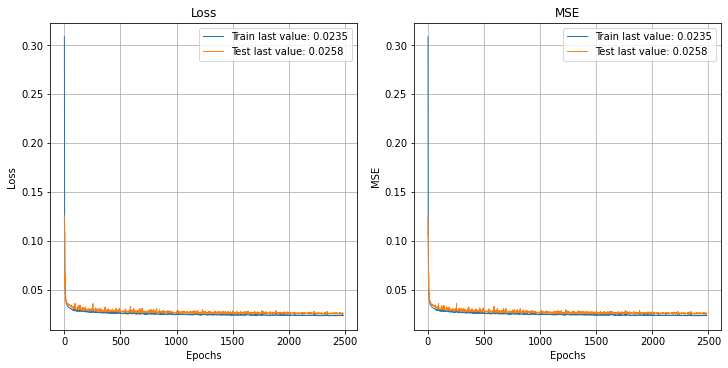

In [14]:
plot_history(hist_teacher.history)
plt.show()

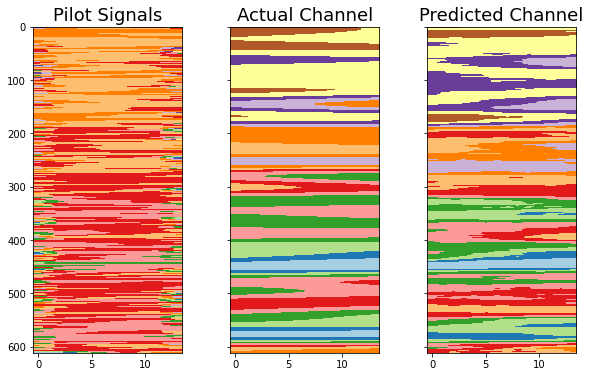

In [15]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = teacher_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

6.2 Student Model

Train the student model using teacher model and training data. Make an example prediction.

In [16]:
import keras
distiller = Distiller(student=student_model, teacher=teacher_model)
loss_fn = keras.losses.MeanSquaredError()

distiller.compile(optimizer='adam',
                            metrics=['mse'],
                            student_loss_fn=loss_fn,
                            distillation_loss_fn=keras.losses.KLDivergence(),
                            alpha=0.1,
                            temperature=20)

es = EarlyStopping(monitor='val_student_loss', 
                   patience=150, 
                   #min_delta=0.000001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

hist_distill = distiller.fit(trainData, trainLabels, 
                              epochs=10000,
                              verbose=0,
                              callbacks=[es,TqdmCallback(verbose=1, desc='DL training')],
                              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 1091.
Epoch 1241: early stopping


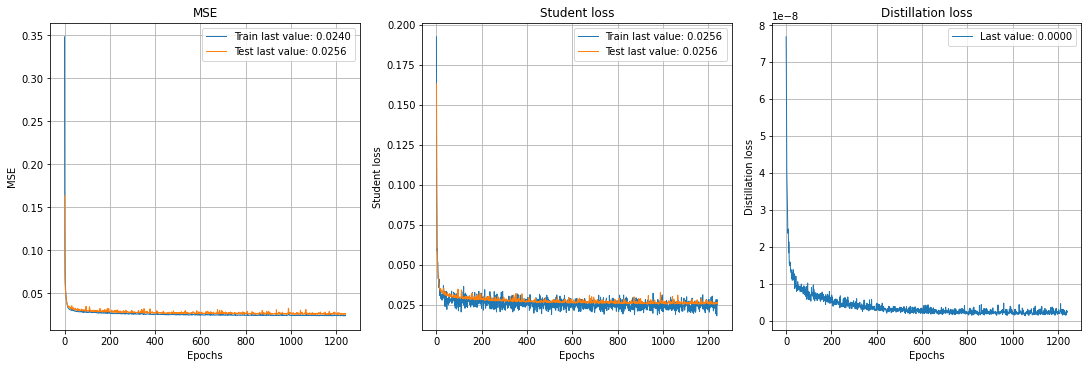

In [17]:
plot_history(hist_distill.history)
plt.show()

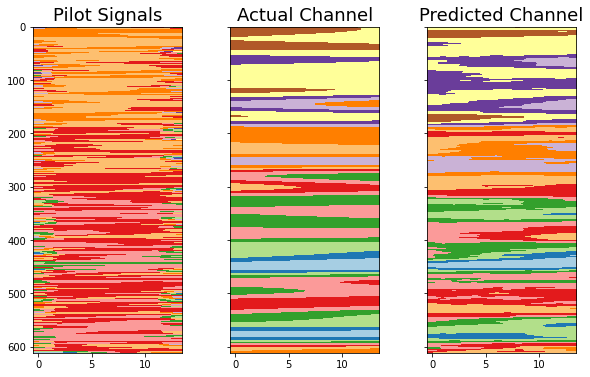

In [18]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = student_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

### 7. Adversarial Machine Learning Attacks.

The previous models are not compatible with `Cleverhans` attack library. We add a dummy layer to make them `Cleverhans` compatible.

#### 7.1 Generate malicious inputs for the undefended model

In [19]:
from keras.layers import Dense, Flatten
student_copy = tf.keras.models.clone_model(distiller.student)
for layer in student_copy.layers:
    	layer.trainable = False

student_copy.add(Flatten())
student_copy.add(Dense(2, activation='softmax'))
student_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
logits_model_student = tf.keras.Model(student_copy.input, student_copy.output)

#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []

eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)

    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model_student, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model_student, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())
        
        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation_def_distill.csv', mode='a', header=False, index=False)

[(1.0, 'FGSM'), (0.5, 'PGD'), (0.5, 'MIM'), (0.1, 'BIM'), (0.1, 'PGD'), (0.5, 'BIM'), (0.5, 'FGSM'), (0.1, 'MIM'), (1.0, 'MIM'), (1.0, 'BIM'), (2.0, 'FGSM'), (2.0, 'BIM'), (3.0, 'FGSM'), (0.1, 'FGSM'), (3.0, 'PGD'), (3.0, 'BIM'), (2.0, 'MIM'), (3.0, 'MIM'), (1.0, 'PGD'), (2.0, 'PGD')]


  0%|          | 0/32 [00:00<?, ?it/s]

#### 7.2 Generate malicious inputs for the defended model (i.e. `student_model`)

In [21]:
model_copy = tf.keras.models.clone_model(model)
for layer in model_copy.layers:
    	layer.trainable = False

model_copy.add(Flatten())
model_copy.add(Dense(2, activation='softmax'))
model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
logits_model = tf.keras.Model(model_copy.input, model_copy.output)
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]
eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)
    #for eps_val in eps_vals:
    #  for attack in attacks:
    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())
        
        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation.csv', mode='a', header=False, index=False)

[(2.0, 'MIM'), (0.5, 'PGD'), (3.0, 'BIM'), (3.0, 'PGD'), (1.0, 'FGSM'), (2.0, 'PGD'), (1.0, 'MIM'), (1.0, 'PGD'), (1.0, 'BIM'), (3.0, 'FGSM'), (0.1, 'BIM'), (0.1, 'FGSM'), (0.5, 'BIM'), (2.0, 'BIM'), (0.5, 'FGSM'), (0.1, 'PGD'), (3.0, 'MIM'), (2.0, 'FGSM'), (0.5, 'MIM'), (0.1, 'MIM')]


  0%|          | 0/32 [00:00<?, ?it/s]

### 8. Attack results

In [23]:
COL_NAMES = ['Malicious_Distance','Real_Predicted_MSE','Malicious_Predicted_MSE','MalOut_RealOut_Diff'
             ,'Attack','eps']
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD']

df_undefended = pd.read_csv('channel_estimation.csv', names=COL_NAMES)
df_undefended = df_undefended.query("Malicious_Predicted_MSE < 1.0").sort_values(by=['Attack'])

df_distilled = pd.read_csv('channel_estimation_def_distill.csv', names=COL_NAMES).sort_values(by=['Attack'])
df_distilled = df_distilled.query("Malicious_Predicted_MSE < 1.0")
df_distilled.sample(10)

,Malicious_Distance,Real_Predicted_MSE,Malicious_Predicted_MSE,MalOut_RealOut_Diff,Attack,eps
611,2.800021,0.018313,0.019575,0.819117,BIM,2.0
125,2.800014,0.039694,0.040615,0.882066,BIM,0.5
272,4.200001,0.012887,0.016460,1.442788,FGSM,3.0
154,2.799999,0.028059,0.029071,0.834533,PGD,3.0
493,0.140001,0.034496,0.034492,0.048550,FGSM,0.1
128,2.800005,0.039694,0.040679,0.837483,MIM,1.0
353,0.140000,0.031892,0.031925,0.041318,FGSM,0.1
144,1.400000,0.028059,0.028163,0.463262,PGD,0.1
537,2.800003,0.033426,0.035785,0.779131,MIM,3.0
420,1.400000,0.052117,0.052598,0.475293,FGSM,1.0


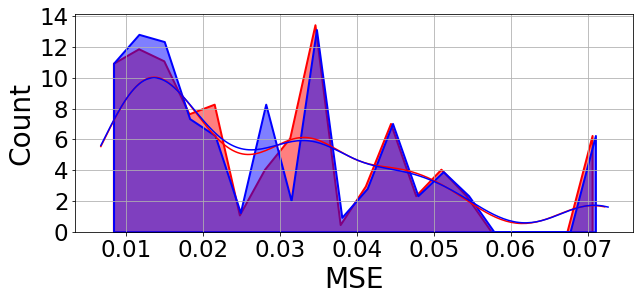

In [24]:
fig,ax = plt.subplots(1, 1, figsize=(10, 4))
sns.histplot(data=df_undefended, x='Malicious_Predicted_MSE', element="poly",
             cumulative=False, lw=2,stat='percent', log_scale=(False,False),
             color='red',kde=True,cbar=True,
             bins=20)
sns.histplot(data=df_distilled, x='Malicious_Predicted_MSE', element="poly",
             cumulative=False, lw=2,stat='percent', log_scale=(False,False),
             color='blue',kde=True,cbar=True,
             bins=20)
plt.xlabel(r'MSE', fontsize=28)
plt.ylabel(r'Count', fontsize=28)
plt.setp(ax.get_xticklabels(), fontsize=23)
plt.setp(ax.get_yticklabels(), fontsize=23)
plt.grid()
plt.show()

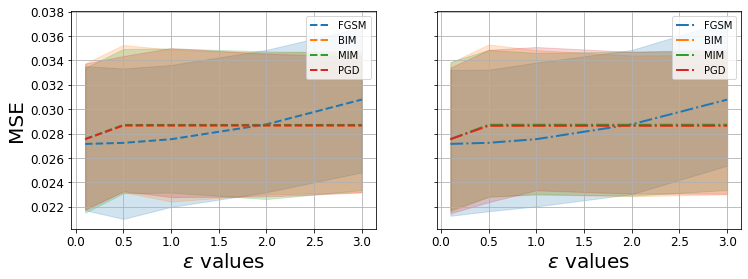

In [25]:
fig,ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for attack in attacks:
    df_tmp = df_undefended.query("Attack=='" + attack + "'" )
    sns.lineplot(data=df_tmp, x='eps', ax=ax[0], y='Malicious_Predicted_MSE', ls='--', lw=2, label=attack)
    
    df_tmp = df_distilled.query("Attack=='" + attack + "'" )
    sns.lineplot(data=df_tmp, x='eps', ax=ax[1], y='Malicious_Predicted_MSE', ls='-.', lw=2, label=attack)

for i in range(2):
    ax[i].set_ylabel('MSE', fontsize=20)
    ax[i].set_xlabel(r'$\epsilon$ values', fontsize=20)
    ax[i].legend()
    ax[i].set(yscale="linear")
    ax[i].grid()
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)

plt.show()